## SIX Case Study - Future of Cash

This exploratory analysis was created for the SIX Case Study on the Future of Cash.

SIX provided a dataset with synthetic transaction data of real Zurich ATM locations. The goal was to describe the data and awnser the following points:

(1) Have a look at the data sample and give an overview on the current ATM situation in Zurich:

- What data do you have and what are some main characteristics?
- What is the distribution of ATMs in Zurich e.g. among the banks, etc.? 
- What is the distribution of the transactions (e.g. depending on the location, etc.)? Can you see any patterns? 

(2) Assuming you would like to add more analysis to this presentation, but you had to realize that the available data is not sufficient. What additional data could be useful? What would be additional interesting questions to answer? 

This Notebook is not a final awnser to the case study, but rather just some exploratory analysis I created in preperation for the workshop.

##### 1) Imports and Global Settings

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib as mpl
from cycler import cycler
plt.style.use('seaborn-whitegrid')

import folium
from folium.plugins import MarkerCluster, FloatImage
from folium import plugins, FeatureGroup, LayerControl, Map, Marker
from geopy.geocoders import Nominatim

import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore') #hide depreciation warnings ('default' to show again) :-)

##### 2) Load in Data

In [52]:
#Load in Transaction Data (Sheet Trx)
df_trx = pd.read_excel('20210225_ATM_dummy_data_EN.xlsx',sheet_name='Trx')
df_trx.head()

,Month,ATM_ID,Location_Description,Street_Number,Postal_Code,City,Agency,Bank_Name,Location_Type,Coordinates,...,Longitude,Accessability,Withdrawal,Withdrawal_CHF,Transactions_Inquiry,Balance_Inquiry,Withdrawal_Own_Bank,Withdrawal_CHF_Own_Bank,Withdrawal_Foreign_Bank,Withdrawal_CHF_Foreign_Bank
0,2020-05-31,23,UBS ZH Paradeplatz,Paradeplatz 6,8001,Zuerich,UBS Zuerich Paradeplatz,UBS Switzerland AG,FINANCIAL_INSTITUTION,"47,3695; 8,5382",...,8.5382,TWENTY_FOUR_H,1887,912230,336,29,1714,841530,173,70700
1,2020-05-31,38,UBS ZH Paradeplatz,Paradeplatz 6,8001,Zuerich,UBS Zuerich Paradeplatz,UBS Switzerland AG,FINANCIAL_INSTITUTION,"47,3695; 8,5382",...,8.5382,TWENTY_FOUR_H,865,456450,163,28,758,416070,107,40380
2,2020-05-31,48,UBS ZH Paradeplatz,Paradeplatz 6,8001,Zuerich,UBS Zuerich Paradeplatz,UBS Switzerland AG,FINANCIAL_INSTITUTION,"47,3695; 8,5382",...,8.5382,TWENTY_FOUR_H,1120,726170,423,21,981,634500,139,91670
3,2020-05-31,52,UBS ZH Paradeplatz,Paradeplatz 6,8001,Zuerich,UBS Zuerich Paradeplatz,UBS Switzerland AG,FINANCIAL_INSTITUTION,"47,3695; 8,5382",...,8.5382,TWENTY_FOUR_H,1770,1173100,308,39,1513,1065890,257,107210
4,2020-05-31,65,UBS ZH Loewenplatz,Seidengasse 17,8001,Zuerich,UBS Zuerich Loewenplatz,UBS Switzerland AG,FINANCIAL_INSTITUTION,"47,3754; 8,5370",...,8.5370,TWENTY_FOUR_H,2098,801640,137,81,1536,660650,562,140990


In [53]:
#Load in ATM Reference Data (Sheet Ref)
df_ref = pd.read_excel('20210225_ATM_dummy_data_EN.xlsx',sheet_name='Reference Data')
df_ref.head()

,ATM_ID,Agency,Bank_Name,Street_Number,Postal_Code,City,Long_Descr.,Location_Type,Coordinates,Latitude,Longitude,Accessibility
0,23,UBS Zuerich Paradeplatz,UBS Switzerland AG,Paradeplatz 6,8001,Zuerich,UBS Zuerich Paradeplatz,FINANCIAL_INSTITUTION,"47,3695; 8,5382",47.3695,8.5382,TWENTY_FOUR_H
1,38,UBS Zuerich Paradeplatz,UBS Switzerland AG,Paradeplatz 6,8001,Zuerich,UBS Zuerich Paradeplatz,FINANCIAL_INSTITUTION,"47,3695; 8,5382",47.3695,8.5382,TWENTY_FOUR_H
2,48,UBS Zuerich Paradeplatz,UBS Switzerland AG,Paradeplatz 6,8001,Zuerich,UBS Zuerich Paradeplatz,FINANCIAL_INSTITUTION,"47,3695; 8,5382",47.3695,8.5382,TWENTY_FOUR_H
3,52,UBS Zuerich Paradeplatz,UBS Switzerland AG,Paradeplatz 6,8001,Zuerich,UBS Zuerich Paradeplatz,FINANCIAL_INSTITUTION,"47,3695; 8,5382",47.3695,8.5382,TWENTY_FOUR_H
4,65,UBS Zuerich Loewenplatz,UBS Switzerland AG,Seidengasse 17,8001,Zuerich,UBS Zuerich Loewenplatz,FINANCIAL_INSTITUTION,"47,3754; 8,5370",47.3754,8.5370,TWENTY_FOUR_H


##### 3) Fill Missing Values

Some ATM's have an adress, but no coordinates. For Visualization purposes Coordinates are easier to deal with. Using the Foursquare API we get the missing coordinates.

In [54]:
# Foursquare API Information
CLIENT_ID = 'P2EOKHT5EE1P5MWHUXY5J2ROSOCVQAWSPKILPKK1F1DMSENT' # your Foursquare ID
CLIENT_SECRET = 'KDVHB0PADA3SWDUZOG3P3SCAOUJE2FYAQJFBUVBC0GH1BHW5' # your Foursquare Secret
VERSION = '20180604'

# Get indexes of ATMs where we dont have coordinates
missing_ind = np.where(pd.isnull(df_ref['Latitude']))

coordinates_still_missing = [] #initialise list for those adresses which foursquare was unsuccessful

for val in missing_ind[0]:
    latitude = ''
    longitude = ''
    try:
        address = df_ref.loc[val, 'Street_Number'] + str(', Zurich, Switzerland')
        geolocator = Nominatim(user_agent="foursquare_agent")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        print(str('Address: '), address, str("Coordinates: "),latitude, longitude, str("|DF index: "),val)
        df_ref.loc[val, 'Latitude'] = latitude
        df_ref.loc[val, 'Longitude'] = longitude
    except:
        print("Couldn't find Adress for: ", address)
        coordinates_still_missing.append(address)
        pass

print('Done, the following coordinates are still missing:')
print(coordinates_still_missing)

Address:  Molkenstrasse. 15, Zurich, Switzerland Coordinates:  47.3764213 8.5264559 |DF index:  68
Address:  Seefeldstrasse 1, Zurich, Switzerland Coordinates:  47.3652354 8.5481418 |DF index:  69
Address:  Uraniastrasse 4, Zurich, Switzerland Coordinates:  47.374689 8.5394436 |DF index:  70
Address:  Seefeldstrasse 1, Zurich, Switzerland Coordinates:  47.3652354 8.5481418 |DF index:  71
Address:  In Böden 174, Zurich, Switzerland Coordinates:  47.4201299 8.5079236 |DF index:  72
Address:  Ohmstrasse 2/4, Zurich, Switzerland Coordinates:  47.4121222 8.5460461 |DF index:  73
Address:  Weinbergstrasse 161, Zurich, Switzerland Coordinates:  47.3908241 8.539244 |DF index:  74
Address:  Limmatquai 58, Zurich, Switzerland Coordinates:  47.3717157 8.5429951 |DF index:  75
Address:  Limmatquai 58, Zurich, Switzerland Coordinates:  47.3717157 8.5429951 |DF index:  76
Address:  ZUERICHSTR. 55, Zurich, Switzerland Coordinates:  47.2762189 8.4509401 |DF index:  77
Address:  Ohmstrasse 2/4, Zurich,

In [55]:
# Save to excel 
df_ref.to_excel('Adjusted_DataSet_wCoordinates.xlsx')

Switch to Excel, and find the last coordinates manually using google maps (rename file to *v2). Then save the excel and reload.

In [56]:
df_ref = pd.read_excel('Adjusted_DataSet_wCoordinates_v2.xlsx')
df_ref = df_ref.drop(columns=['Unnamed: 0','Coordinates'])
df_ref_noNA = df_ref.dropna(subset=['Latitude', 'Longitude']) # Create DF excluding ATMs with no Coordinates

#### 4) Map Visualizations
##### 4.1) All ATMs (no weighting)

In [57]:
Center = (47.37388549102269, 8.53957665979672) #define center of zurich
map = folium.Map(location=Center, zoom_start=12, width=600,height=400) #initialise map objecr

# Create a title
loc = 'All ATMs in Zuerich'
title_html = '''
             <h3 align="left" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   
map.get_root().html.add_child(folium.Element(title_html))

# Loop through all ATMs
for lat, lng, label in zip(df_ref_noNA.Latitude, df_ref_noNA.Longitude, df_ref_noNA.ATM_ID):
    folium.features.CircleMarker(
        [lat, lng],
        radius=2,
        popup=str(label),
        color='blue',
        fill = True,
        fill_color='blue',
        fill_opacity=1
    ).add_to(map)

map  # display map

##### 4.2) ATMs in Zurich using a clustered view

This view uses folium's "ClusterMarker" function, and aggregates the points into clusters. This is suitable for interactive use, but not for screenshots on a PPT presentation.

In [58]:
#Map 2: All ATM's (Clustered view) 

map = folium.Map(location=Center, zoom_start=12, width=600, height=400)

loc = 'All ATMs in Zuerich (Clustered)'
title_html = '''
             <h3 align="left" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   
map.get_root().html.add_child(folium.Element(title_html))


marker_cluster = MarkerCluster().add_to(map)

for lat, lng, label in zip(df_ref_noNA.Latitude, df_ref_noNA.Longitude, df_ref_noNA.ATM_ID):
    folium.Marker(location=[lat,lng],
                  popup=str(label)).add_to(marker_cluster)
map

##### 4.3) ATM Heatmap

The below graph depicts a heatmap of the ATMs in Zurich. We can see there are some hotspots like Downtown Zurich, Trainstations, and other hubs for public transportation.


In [59]:
map = folium.Map(location=Center, zoom_start=12, width=600,height=400)
loc = 'All ATMs in Heatmap'
title_html = '''
             <h3 align="left" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   
map.get_root().html.add_child(folium.Element(title_html))

map.add_child(plugins.HeatMap(list(zip(df_ref_noNA.Latitude, df_ref_noNA.Longitude)), radius=12))

for lat, lng, label in zip(df_ref_noNA.Latitude, df_ref_noNA.Longitude, df_ref_noNA.ATM_ID):
    folium.features.CircleMarker(
        [lat, lng],
        radius=1,
        popup=str(label),
        color='black',
        opacity = 0.1
    ).add_to(map)

map

##### 4.4) Interactive Map allowing to filter by Bank

What if we want to look at each Banks ATM distribution? The map below allows us to filter ATMs based on the Bank. We can see that most ATM "Hubs" have all ATMs of all 3 major banks within very close vicinity to each other. Why could this be? Further down we look at the percentages of customers (own v. foreign). Maybe this can explain a bit more

In [60]:
# Initialize map object
map = folium.Map(location=Center, zoom_start=12, width=600,height=400) 

# Set title
loc = 'All ATMs in Zuerich (Selectable by Bank)'
title_html = '''
             <h3 align="left" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   
map.get_root().html.add_child(folium.Element(title_html))

# Split dataframe into the top 4 banks and 'other'
Major_Banks = ['UBS Switzerland AG','Zuercher Kantonalbank','Credit Suisse AG','Migros Bank'] #Defining top 4
UBS = df_ref_noNA.loc[(df_ref_noNA.Bank_Name == 'UBS Switzerland AG')]
ZKB = df_ref_noNA.loc[(df_ref_noNA.Bank_Name == 'Zuercher Kantonalbank')]
CS = df_ref_noNA.loc[(df_ref_noNA.Bank_Name == 'Credit Suisse AG')]
Migros = df_ref_noNA.loc[(df_ref_noNA.Bank_Name == 'Migros Bank')]
Other = df_ref_noNA.loc[(~df_ref_noNA.Bank_Name.isin(Major_Banks))]

# Initialise the feature groups (needed for interactive filtering of banks)
UBS_Group = FeatureGroup(name="UBS ATMs") 
ZKB_Group = FeatureGroup(name="ZKB ATMs")
CS_Group = FeatureGroup(name="CS ATMs")
Migros_Group = FeatureGroup(name="Migros ATMs")
Other_Group = FeatureGroup(name="Other ATMs")

# Add feature groups to map
UBS_Group.add_to(map)
ZKB_Group.add_to(map)
CS_Group.add_to(map)
Migros_Group.add_to(map)
Other_Group.add_to(map)
LayerControl().add_to(map) #initialise LayerControl (= Button to apply filter)


# Loop through all Banks. TO DO: Put all the loops below in 1 loop
# ZKB : Purple
for lat, lng, label in zip(ZKB.Latitude, ZKB.Longitude, ZKB.ATM_ID):
    folium.features.CircleMarker(
        [lat, lng],
        radius=3,
        popup=str(label),
        color='purple',
        fill = True,
        fill_color='purple',
        fill_opacity=0.1,
        opacity = 0.6
    ).add_to(ZKB_Group)

# UBS : Blue
for lat, lng, label in zip(UBS.Latitude, UBS.Longitude, UBS.ATM_ID):
    folium.features.CircleMarker(
        [lat, lng],
        radius=3,
        popup=str(label),
        color='blue',
        fill = True,
        fill_color='blue',
        fill_opacity=0.1,
        opacity = 0.6
    ).add_to(UBS_Group)

# CS : Red
for lat, lng, label in zip(CS.Latitude, CS.Longitude, CS.ATM_ID):
    folium.features.CircleMarker(
        [lat, lng],
        radius=3,
        popup=str(label),
        color='red',
        fill = True,
        fill_color='red',
        fill_opacity=0.1,
        opacity = 0.6
    ).add_to(CS_Group)

# Migros : Orange
for lat, lng, label in zip(Migros.Latitude, Migros.Longitude, Migros.ATM_ID):
    folium.features.CircleMarker(
        [lat, lng],
        radius=3,
        popup=str(label),
        color='orange',
        fill = True,
        fill_color='orange',
        fill_opacity=0.1,
        opacity = 0.6
    ).add_to(Migros_Group)

# 'Other' : Grey
for lat, lng, label in zip(Other.Latitude, Other.Longitude, Other.ATM_ID):
    folium.features.CircleMarker(
        [lat, lng],
        radius=3,
        popup=str(label),
        color='grey',
        fill = True,
        fill_color='grey',
        fill_opacity=0.1,
        opacity = 0.8
    ).add_to(Other_Group)

# Add Legend to the right of the map
image_file = 'https://raw.githubusercontent.com/feljost/FutureOfCash_CaseStudy/main/Map_Legend_m.png'
FloatImage(image_file, bottom=54, left=70).add_to(map)    

map

##### 4.5) Map of ATMs by Attribute

Now let's add weightings. First let's look at the Sum of the Withdrawal Amounts. We have to sum them together by adress, as we don't want the markers to just stack on top of each each other. This is needed because often there are multiple ATMs right next to each other, having the same adress and same coordinates. 

In [61]:
# Group the ATM transactions
df_trx_grp = df_trx.groupby(['Street_Number'])['Withdrawal_CHF','Withdrawal'].sum().reset_index() 

# Get the rest of the infos from the Reference Sheet of the Dataset
df_ref_grp = df_ref.drop(['ATM_ID'],axis=1)
df_ref_grp = df_ref_grp.drop_duplicates(subset=['Street_Number'], keep='last') 

# Merge the two together on adress as they seem to be unique and we can't use ATM ID
df_trx_grp_m = pd.merge(left=df_trx_grp, right=df_ref_grp, how='left', left_on='Street_Number', right_on='Street_Number')
df_trx_grp_noNA = df_trx_grp_m.dropna(subset=['Latitude', 'Longitude']) # get rid of ATMs w/o Coordinates

In [62]:
# Initialize map object
map = folium.Map(location=Center, zoom_start=12, width=600,height=400)

# Set title
loc = 'All ATMs in Zuerich Weighted by CHF Withdrawn'
title_html = '''
             <h3 align="left" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   
map.get_root().html.add_child(folium.Element(title_html))

# Set the colors (same color scheme as above)
df_trx_grp_noNA['Color'] = 'gray' 
df_trx_grp_noNA.loc[(df_trx_grp_noNA.Bank_Name == 'Credit Suisse AG'),'Color'] = 'red'
df_trx_grp_noNA.loc[(df_trx_grp_noNA.Bank_Name == 'Migros Bank'),'Color'] = 'blue'
df_trx_grp_noNA.loc[(df_trx_grp_noNA.Bank_Name == 'UBS Switzerland AG'),'Color'] = 'orange'
df_trx_grp_noNA.loc[(df_trx_grp_noNA.Bank_Name == 'Zuercher Kantonalbank'),'Color'] = 'purple'

max_CHF = df_trx_grp_noNA.Withdrawal_CHF.max() # get the maximum amount of CHF withdrawn by ATM Location

# loop through all ATM locations
for lat, lng, CHF, col, bnk in zip(df_trx_grp_noNA.Latitude, 
                                   df_trx_grp_noNA.Longitude, 
                                   df_trx_grp_noNA.Withdrawal_CHF,
                                   df_trx_grp_noNA.Color,
                                   df_trx_grp_noNA.Bank_Name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=max((CHF/max_CHF)*50,1), # Size of points weighted by CHF Amount
        popup=str(CHF) +  "CHF Withdrawn \n from " + str(bnk),
        color=col,
        fill = True,
        fill_color=col,
        fill_opacity=0.6
    ).add_to(map)

# Add Legend
image_file = 'https://raw.githubusercontent.com/feljost/FutureOfCash_CaseStudy/main/Map_Legend_m.png'
FloatImage(image_file, bottom=54, left=70).add_to(map)    

map  

##### 4.5) Map of ATMs by Usage (#Withdrawals)

Similar to above, let's now weigh them by their usage (amount of withdrawals).

In [63]:
# Initialize map object
map = folium.Map(location=Center, zoom_start=12, width=600,height=400)

# Set title
loc = 'All ATMs in Zuerich Weighted by Usage (Amount of Withdrawals)'
title_html = '''
             <h3 align="left" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   
map.get_root().html.add_child(folium.Element(title_html))

max_with = df_trx_grp_noNA.Withdrawal.max() # find the maximum amount of withdrawal for weighting

# Loop through all ATM locations
for lat, lng, with_, col, bnk in zip(df_trx_grp_noNA.Latitude, 
                                   df_trx_grp_noNA.Longitude, 
                                   df_trx_grp_noNA.Withdrawal,
                                   df_trx_grp_noNA.Color,
                                   df_trx_grp_noNA.Bank_Name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=max((with_/max_with)*10,1), # Set size based on relative usage of ATMs
        popup=str(with_) +  "Transactions \n from " + str(bnk),
        color=col,
        fill = True,
        fill_color=col,
        fill_opacity=0.6
    ).add_to(map)

image_file = 'https://raw.githubusercontent.com/feljost/Cash_Analysis_SIX_CaseStudy/main/Map_Legend_m.png'
FloatImage(image_file, bottom=54, left=70).add_to(map)        

map  

Again, it seems that wherever ATMs are used often, all major banks seem to have ATMs within close vicinity. This seems to be true for the top 3 banks (ZKB, CS, and UBS).

This makes sense as Customers (especially those of the top 3 banks) tend to use the ATM of their own bank.

This forces each of the top 3 banks to deploy and maintain ATMs where other ATMs already exist. If we had a solution of a bank-agnostic ATM, we could cut the amount of ATMs in these hubs by roughly 1/3. This ATM could be offered by SIX or another institution (e.g. worldline?). This could be beneficial for the banks and for SIX.

#### 5) Other Graphs

Let's create some other helpful graphs to understand the ATM landscape in Zurich.

##### 5.1) Withdrawal Amount / Withdrawal Frequency by Bank (Pie Chart)

Below we create 2 Pie Charts to understand how withdrawals and frequency are distributed.

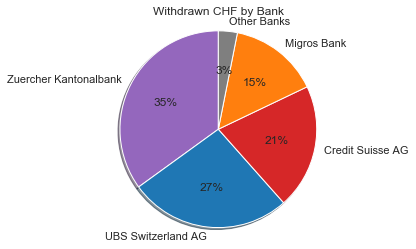

In [64]:
# Banks ordered by withdrawal amount

bank_with = df_trx.groupby(['Bank_Name'])['Withdrawal_CHF'].sum().reset_index()
bank_with = bank_with.sort_values(by=['Withdrawal_CHF'],ascending=False)

btm_grp = bank_with['Withdrawal_CHF'][4:].sum() # sum all small banks into 1 group

bank_with = bank_with[:4] #keep top 4
bank_with = bank_with.append({'Bank_Name':"Other Banks",
                              'Withdrawal_CHF':btm_grp}, ignore_index=True) #add grouped banks

#Plot
fig1, ax1 = plt.subplots()
ax1.pie(bank_with['Withdrawal_CHF'], 
        labels=bank_with['Bank_Name'],
        autopct='%1.0f%%',
        colors=('tab:purple','tab:blue','tab:red','tab:orange','tab:gray'),
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Withdrawn CHF by Bank") 
plt.show()

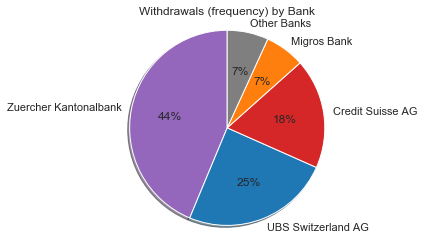

In [65]:
# Banks ordered by numbers of withdrawal

bank_with = df_trx.groupby(['Bank_Name'])['Withdrawal'].sum().reset_index()
bank_with = bank_with.sort_values(by=['Withdrawal'],ascending=False)

btm_grp = bank_with['Withdrawal'][4:].sum() # sum all small banks into 1 group

bank_with = bank_with[:4] #keep top 4
bank_with = bank_with.append({'Bank_Name':"Other Banks",
                              'Withdrawal':btm_grp}, ignore_index=True) #add grouped banks

#Plot
fig1, ax1 = plt.subplots()
ax1.pie(bank_with['Withdrawal'], 
        labels=bank_with['Bank_Name'],
        autopct='%1.0f%%',
        colors=('tab:purple','tab:blue','tab:red','tab:orange','tab:gray'),
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Withdrawals (frequency) by Bank") 
plt.show()

##### 5.2) Average Withdrawal Plots

As these 2 pie charts above seem to differ, especially with Migros Bank, we can have a further look into why this is the case. Below we can see that, on average Migros Bank Customers withdraw a lot more money on average than customers of other banks. Intuitively, these numbers dont seem very likely. I would imagine the average withdrawal amount to be around 100 CHF, not much more. Big payments are usually not done in cash, therefore it is hard to believe that the average withdrawal amount is 2000 CHF.

Text(0.5, 1.0, 'Average Withdrawal amount by Bank')

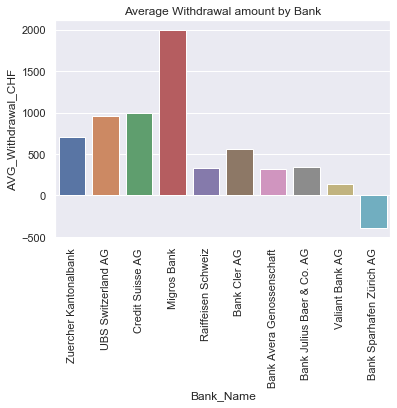

In [66]:
# Compute Average Withdrawal Amount per bank

bank_with = df_trx.groupby(['Bank_Name'])['Withdrawal','Withdrawal_CHF'].sum().reset_index()
bank_with = bank_with.sort_values(by=['Withdrawal'],ascending=False)

bank_with['AVG_Withdrawal_CHF']=bank_with['Withdrawal_CHF']/bank_with['Withdrawal']

ax = sns.barplot(x="Bank_Name", y="AVG_Withdrawal_CHF", data=bank_with)
for item in ax.get_xticklabels():
    item.set_rotation(90)
    
plt.title("Average Withdrawal amount by Bank") 

Perhaps this can be explained with the wierd outliers in Örlikon. Below the barchart shows that the average withdrawal amount is much higher in Örlikon. This could be an outlier in our data, or a mistake. As this is synthetic data, I will assume it is an intentional mistake.

Text(0.5, 1.0, 'Average Withdrawal amount by Postal Code')

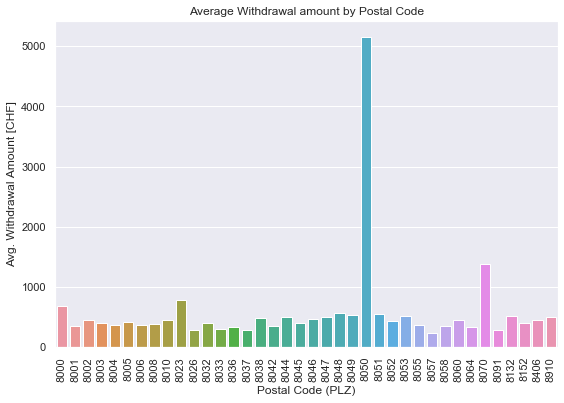

In [67]:
# Create dataframe grouped by postal code
bank_with = df_trx.groupby(['Postal_Code'])['Withdrawal','Withdrawal_CHF'].sum().reset_index()
bank_with = bank_with.sort_values(by=['Withdrawal'],ascending=False)

# compute average
bank_with['AVG_Withdrawal_CHF_PLZ']=bank_with['Withdrawal_CHF']/bank_with['Withdrawal'] 

ax = sns.barplot(x="Postal_Code", y="AVG_Withdrawal_CHF_PLZ", data=bank_with)

fig = plt.gcf()
fig.set_size_inches(9, 6)
ax.set(xlabel='Postal Code (PLZ)', ylabel='Avg. Withdrawal Amount [CHF]')

for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.title("Average Withdrawal amount by Postal Code") 

##### 5.3) Ratio of 'Own' and 'Foreign' Customers.

As described above, each ATM Hub has ATMs of all major banks. Why is this the case? Perhaps people want to go to their 'own' bank rather than an other (foreign) one.

The graph below shows that this definitely is the case!

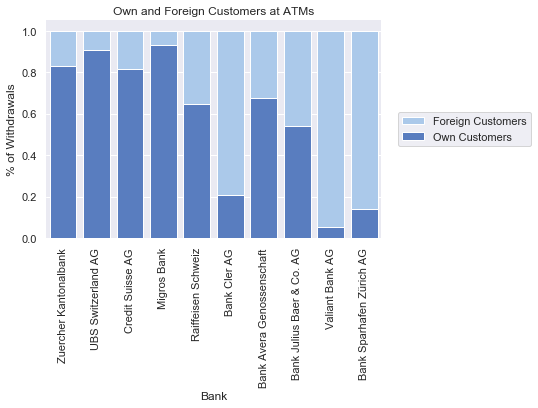

In [68]:
# Percent of Own and Foreign Customers
bank_with = df_trx.groupby(['Bank_Name'])['Withdrawal','Withdrawal_CHF','Withdrawal_Own_Bank','Withdrawal_CHF_Own_Bank','Withdrawal_Foreign_Bank','Withdrawal_CHF_Foreign_Bank'].sum().reset_index()
bank_with = bank_with.sort_values(by=['Withdrawal'],ascending=False)

bank_with['Ratio_With_Own'] = bank_with['Withdrawal_CHF_Own_Bank'] / bank_with['Withdrawal_CHF'] 
bank_with['Ratio_With_Foreign'] = 1 - bank_with['Ratio_With_Own']
bank_with['1'] = 1

sns.set_color_codes("pastel")
ax = sns.barplot(x="Bank_Name", y='1', data=bank_with,
                label = 'Foreign Customers', color = 'b')

sns.set_color_codes("muted")
sns.barplot(x="Bank_Name", y="Ratio_With_Own", data=bank_with,
            label="Own Customers", color="b")

for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.title("Own and Foreign Customers at ATMs") 

ax.legend(loc="center", frameon=True,
         bbox_to_anchor=(1.25, 0.5),borderaxespad=0)
ax.set(ylabel="% of Withdrawals",
       xlabel="Bank")
sns.despine(left=True, bottom=True)


##### 5.4) ATM Profitability

There seem to be major differences in how often an ATM is used and how much money is withdrawn from it. Most scenario's of the SIX' whitepaper on cash predict that cash usage is going to decline over the next 5-7 years. The graph below sets the amount of withdrawals and the withdrawal amount in relation to each other. First we look at graphs using an absolute scale, but then switch to a logarithmic scale.

The graphs can be interpreted as follows:

The bottom left ATMs are not used often, and when they are used, they are not used to withdraw a lot of money. The further up we go, the more money is withdrawn from the ATM. The more to the right we go, the more the ATM is interacted with.

Text(0.5, 1, 'Interactions v. Withdrawal Amount (All ATMs)')

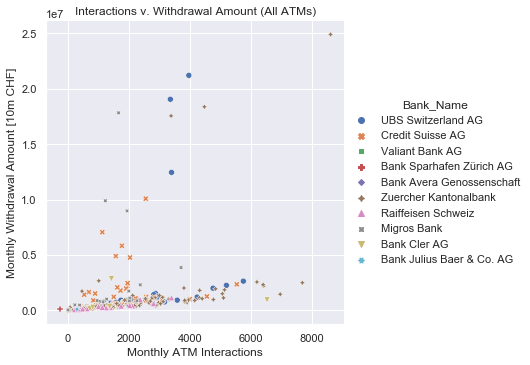

In [69]:
# ATM usage and Withdrawal amount
df_trx['Interactions'] = df_trx['Withdrawal'] + df_trx['Transactions_Inquiry'] + df_trx['Balance_Inquiry'] # get all interactions
ax = sns.relplot(x="Interactions", y="Withdrawal_CHF", hue="Bank_Name", style="Bank_Name",
            data=df_trx)
ax.set(ylabel="Monthly Withdrawal Amount [10m CHF]",
       xlabel="Monthly ATM Interactions")
plt.title("Interactions v. Withdrawal Amount (All ATMs)") 

Text(0.5, 1, 'Interactions v. Withdrawal CHF (without outliers)')

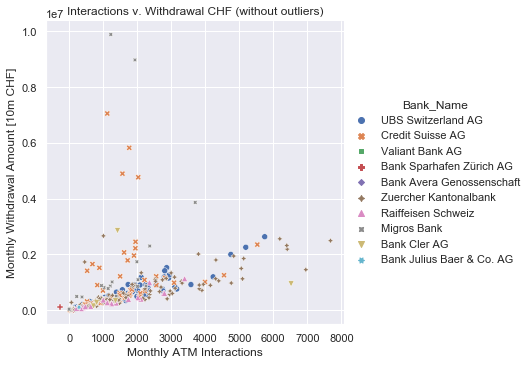

In [70]:
# Get rid of outliers (mostly örlikon ATMs)
df_trx_noO = df_trx.loc[df_trx['Withdrawal_CHF'] < 1 * 1e7]

ax = sns.relplot(x="Interactions", y="Withdrawal_CHF", hue="Bank_Name", style="Bank_Name",
            data=df_trx_noO);

ax.set(ylabel="Monthly Withdrawal Amount [10m CHF]",
       xlabel="Monthly ATM Interactions")

plt.title("Interactions v. Withdrawal CHF (without outliers)") 

Text(0.5, 1, 'Interactions v. Withdrawal')

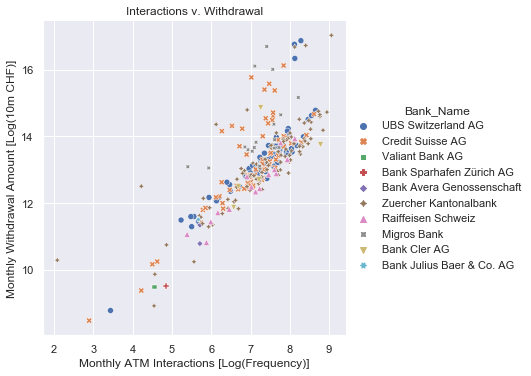

In [71]:
# With logistic Scale


df_trx['Withdrawal_CHF_Adjusted'] = df_trx['Withdrawal_CHF']
df_trx.loc[df_trx.Withdrawal_CHF < 1, 'Withdrawal_CHF_Adjusted'] = 1 # Make sure there are no 0 or negative values as we take the log.
df_trx['Withdrawal_CHF_log'] = np.log(df_trx['Withdrawal_CHF_Adjusted'])

df_trx['Interactions_Adjusted'] = df_trx['Interactions']
df_trx.loc[df_trx.Interactions < 1, 'Interactions_Adjusted'] = 1 # Make sure there are no 0 values as we take the log.
df_trx['Interactions_log'] = np.log(df_trx['Interactions_Adjusted'])

# get rid of special case ATMs which are never used
df_trx_noO = df_trx.loc[df_trx['Withdrawal_CHF'] > 0.01] 
df_trx_noO = df_trx_noO.loc[df_trx['Interactions'] > 1] 

ax= sns.relplot(x="Interactions_log", y="Withdrawal_CHF_log", hue="Bank_Name", style="Bank_Name",
            data=df_trx_noO)
ax.set(ylabel="Monthly Withdrawal Amount [Log(10m CHF)]",
       xlabel="Monthly ATM Interactions [Log(Frequency)]")
plt.title("Interactions v. Withdrawal") 


We can see that not all ATMs seem to be equally profitable. If we want to get rid of ATMs, we could consider getting rid of those ATMS to the bottom left side of the graph.

##### 5.4) Cumulatitive Distributions

The last 2 graphs further depict that ATM withrdrawal amount and frequency of usage is not distributed equally at all. Perhaps many of the ATMs could be taken down, or replaced by bank-agnostic ATMs. 

Text(0.5, 1.0, 'Cumulative Distribution of ATMs')

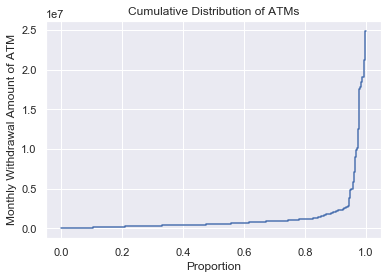

In [72]:
ax = sns.ecdfplot(data=df_trx, y="Withdrawal_CHF")
ax.set(ylabel="Monthly Withdrawal Amount of ATM")
plt.title("Cumulative Distribution of ATMs") 

Text(0.5, 1.0, 'Cumulative Distribution of ATMs')

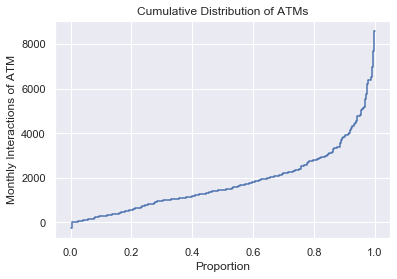

In [73]:
ax = sns.ecdfplot(data=df_trx, y="Interactions")
ax.set(ylabel="Monthly Interactions of ATM")
plt.title("Cumulative Distribution of ATMs") 